In [1]:
import torch
from matplotlib import pyplot as plt

from survae import SurVAE
from survae.calibrate import calc_cs, plot_histogram, plot_cdf
from survae.data import ngon, circles, corners, checkerboard, get_spatial_mnist
from survae.layer import BijectiveLayer, AbsoluteUnit, OrthonormalLayer, MaxTheLayer, SortingLayer

# Visualizing symmetry lines

## Checkerboard

In [ ]:
# TODO this should work with the new and improved API
model_generator = lambda: SurVAE(
    [
        [BijectiveLayer(2, [64] * 5), OrthonormalLayer(2),]
        for _ in range(6)
    ] + [
        [AbsoluteUnit, [1/2], {'learn_q': True}],
    ] + [
        [BijectiveLayer(2, [64] * 5), OrthonormalLayer(2),]
        for _ in range(6)
    ],
)

In [12]:
# TODO replace with above
model_generator = lambda: SurVAE(
    [
        BijectiveLayer(2, [64] * 5), OrthonormalLayer(2),
        BijectiveLayer(2, [64] * 5), OrthonormalLayer(2),
        BijectiveLayer(2, [64] * 5), OrthonormalLayer(2),
        BijectiveLayer(2, [64] * 5), OrthonormalLayer(2),
        BijectiveLayer(2, [64] * 5), OrthonormalLayer(2),
        BijectiveLayer(2, [64] * 5), OrthonormalLayer(2),
        AbsoluteUnit(torch.tensor([1/2, 1/2]), learn_q=True),
        BijectiveLayer(2, [64] * 5), OrthonormalLayer(2),
        BijectiveLayer(2, [64] * 5), OrthonormalLayer(2),
        BijectiveLayer(2, [64] * 5), OrthonormalLayer(2),
        BijectiveLayer(2, [64] * 5), OrthonormalLayer(2),
        BijectiveLayer(2, [64] * 5), OrthonormalLayer(2),
        BijectiveLayer(2, [64] * 5), OrthonormalLayer(2),
    ],
)

models = [model_generator() for _ in range(4)]

In [26]:
for model in models:
    model.train(checkerboard, epochs=100)

Starting training... done in 10.33 seconds
Starting training... done in 10.14 seconds
Starting training... done in 10.22 seconds
Starting training... done in 10.22 seconds


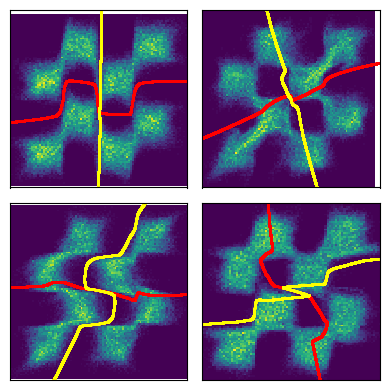

In [27]:
# visualize symmetry axes

n_models = len(models)

n_cols = 2 # set manually
n_rows = n_models // n_cols

axis_len = 8 # sample length for axis visualization
axis_n_samples  = 10_000 # number of samples per axis
distr_n_samples = 100_000 # number of samples for distribution

fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*2, n_rows*2))

for i in range(n_models):
    model = models[i]
    k = i // n_cols

    with torch.no_grad():
        samples = model.sample(distr_n_samples).cpu().numpy()

        _axis  = torch.linspace(-axis_len, axis_len, axis_n_samples)
        _zeros = torch.zeros(axis_n_samples)

        x_axis = torch.stack((_axis, _zeros), dim=1)
        y_axis = torch.stack((_zeros, _axis), dim=1)

        for layer in reversed(model.layers[:9]):
            x_axis = layer.backward(x_axis)
            y_axis = layer.backward(y_axis)

    x_axis = x_axis.cpu()
    y_axis = y_axis.cpu()

    # choose right subfigure
    if n_cols == 1 and n_rows == 1:
        _ax = ax
    elif n_cols == 1 or n_rows == 1:
        _ax = ax[max(k, i%n_cols)]
    else:
        _ax = ax[k, i%n_cols]

    _ax.hist2d(samples[:, 0], samples[:, 1], bins=100)
    _ax.scatter(x_axis[:, 0], x_axis[:, 1], s=1, c="red")
    _ax.scatter(y_axis[:, 0], y_axis[:, 1], s=1, c="yellow")

    _ax.set_xlim(-2.5, 2.5)
    _ax.set_ylim(-2.5, 2.5)
    _ax.set_aspect("equal")

    _ax.set_xticks([])
    _ax.set_yticks([])

plt.tight_layout()
plt.show()

## Other patterns TODO